In [14]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import lightgbm as lgb

In [2]:
# データセットの読み込み
df = sns.load_dataset('diamonds')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1変数EDA

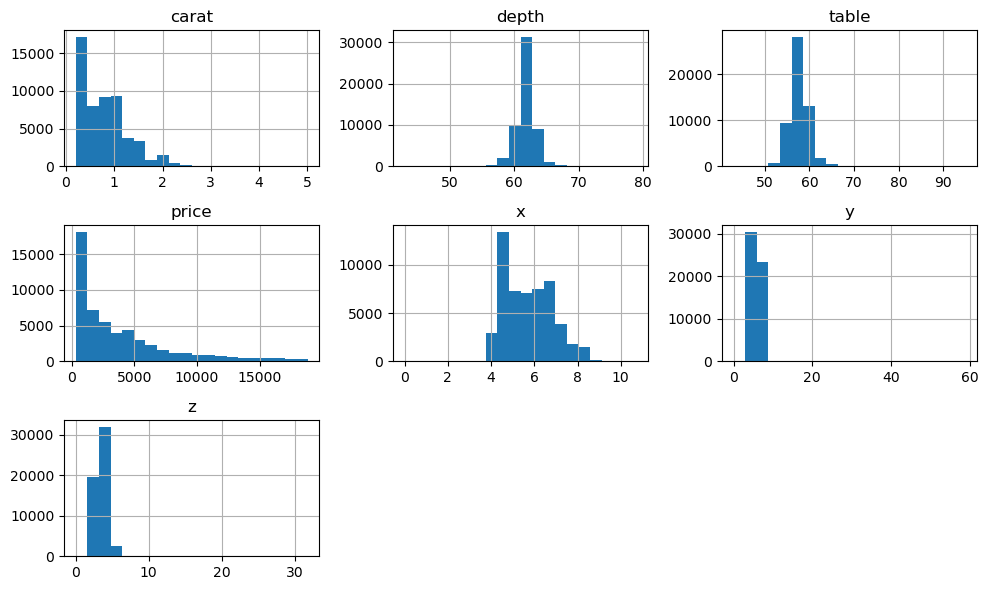

In [3]:
# 数値のヒストグラム
plt.rcParams['figure.figsize'] = (10, 6)
df.hist(bins=20)
plt.tight_layout() 
plt.show()

## 2変数EDA

<AxesSubplot:>

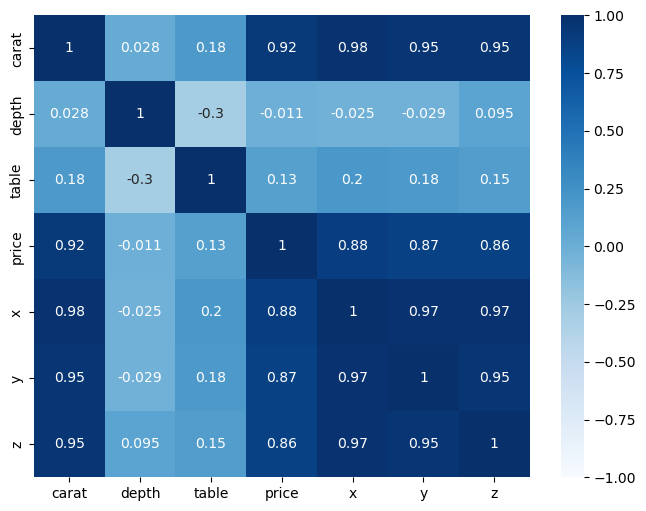

In [4]:
# 相関係数
plt.figure(figsize=(8, 6))
df_corr = df.corr()
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, annot=True, cmap = 'Blues')

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


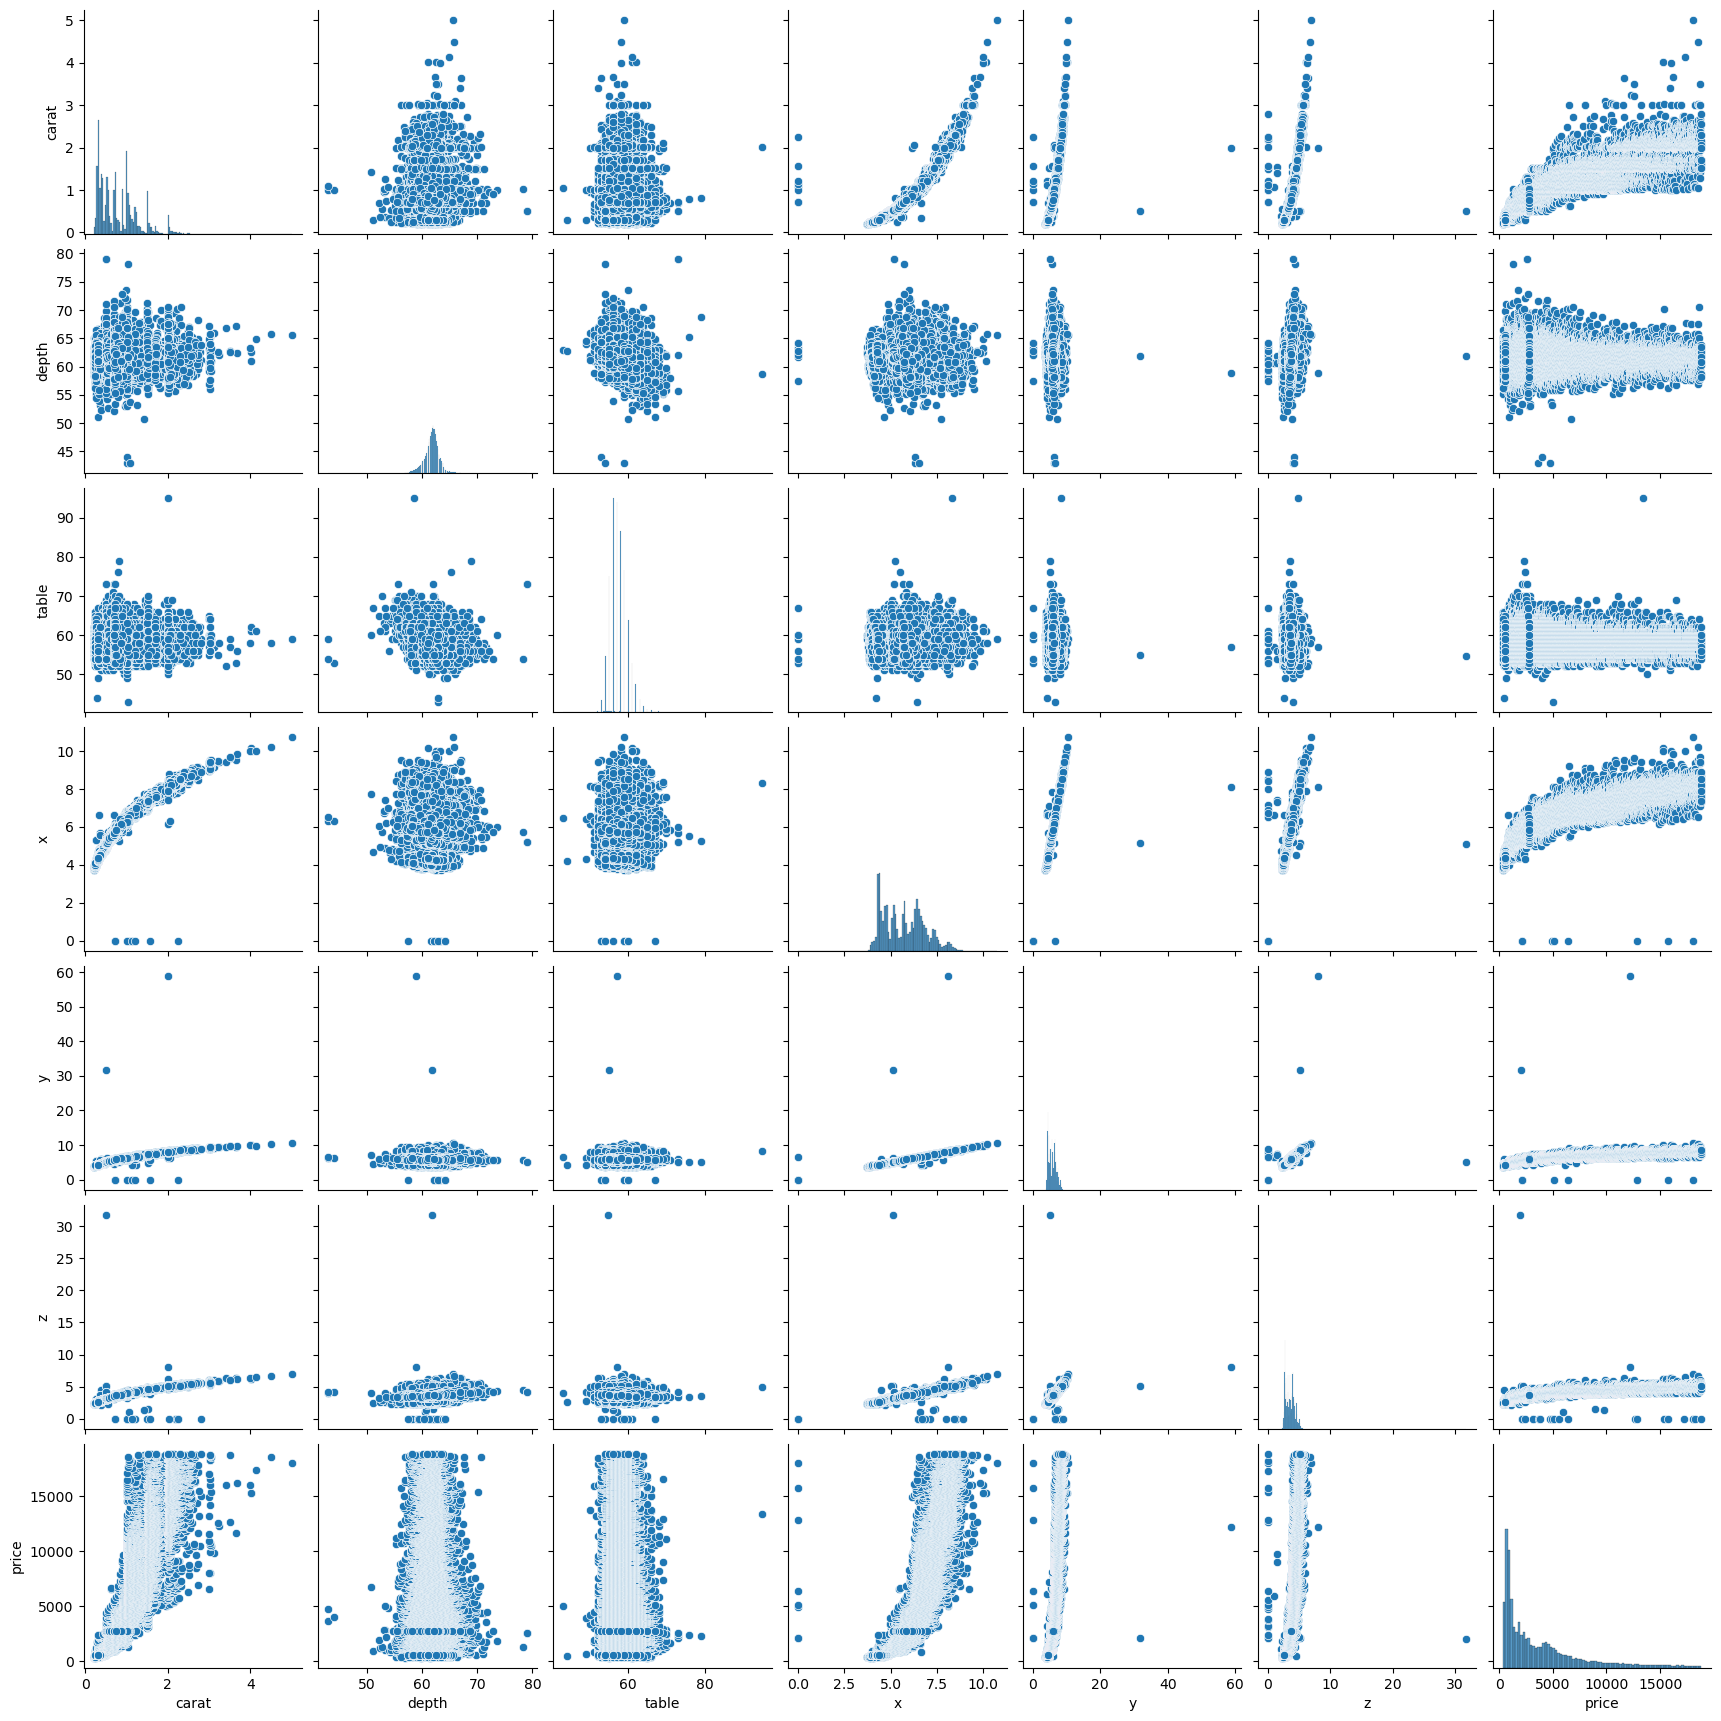

In [5]:
# 数値×数値の散布図
num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
sns.pairplot(df[num_cols], size=2.5)

## カテゴリ変数EDA

In [6]:
# カテゴリ変数の統計情報
df.describe(exclude='number').T

,count,unique,top,freq
cut,53940,5,Ideal,21551
color,53940,7,G,11292
clarity,53940,8,SI1,13065


In [7]:
# カテゴリ変数のリスト
cat_cols = ['cut', 'color', 'clarity']

for col in cat_cols:
    print('%s: %s' % (col, list(df[col].unique())))

cut: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
color: ['E', 'I', 'J', 'H', 'F', 'G', 'D']
clarity: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']


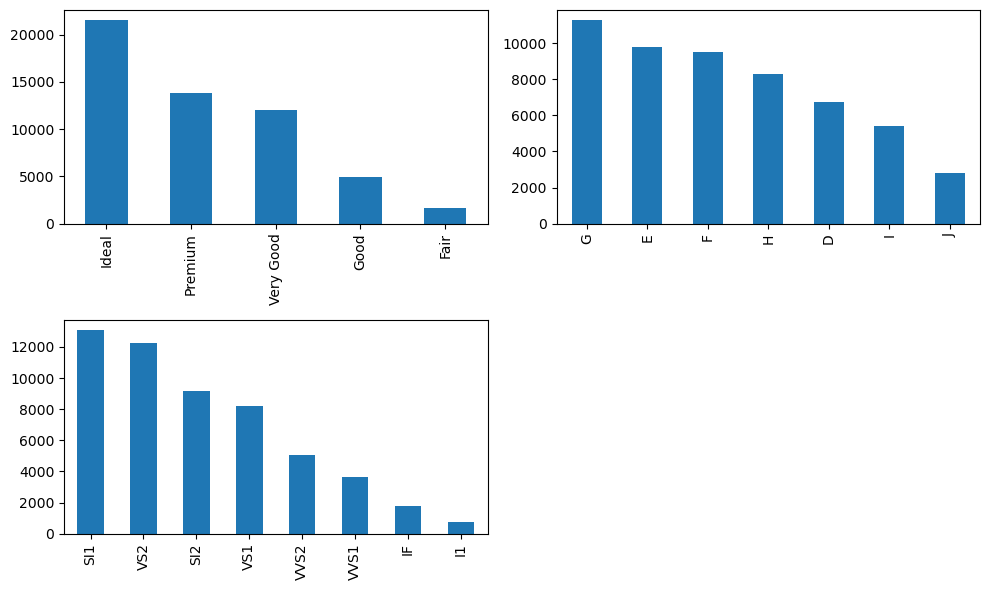

In [8]:
# カテゴリ変数のラベル内訳
plt.rcParams['figure.figsize'] = (10, 6)

for i, name in enumerate(cat_cols):
  ax = plt.subplot(2, 2, i+1)
  df[name].value_counts().plot(kind='bar', ax=ax)

plt.tight_layout() 
plt.show()


## 前処理

In [9]:
# x、y、zが0mmの外れ値の除外
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df.shape

(53920, 10)

In [10]:
# x、y、zが10mm以上の外れ値
df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)]

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
25998,4.01,Premium,I,I1,61.0,61.0,15223,10.14,10.10,6.17
25999,4.01,Premium,J,I1,62.5,62.0,15223,10.02,9.94,6.24
26444,4.00,Very Good,I,I1,63.3,58.0,15984,10.01,9.94,6.31
27130,4.13,Fair,H,I1,64.8,61.0,17329,10.00,9.85,6.43
27415,5.01,Fair,J,I1,65.5,59.0,18018,10.74,10.54,6.98
27630,4.50,Fair,J,I1,65.8,58.0,18531,10.23,10.16,6.72
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12


In [11]:
# x、y、zが10mm以上の外れ値の除外
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
df.shape

(53911, 10)

In [12]:
# 外れ値除外後の統計値
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53911.0,0.797299,0.472363,0.20,0.40,0.70,1.04,3.67
depth,53911.0,61.749335,1.432118,43.00,61.00,61.80,62.50,79.00
table,53911.0,57.456675,2.233991,43.00,56.00,57.00,59.00,95.00
price,53911.0,3929.487340,3985.129937,326.00,949.00,2401.00,5321.50,18823.00
x,53911.0,5.731109,1.118472,3.73,4.71,5.70,6.54,9.86
y,53911.0,5.732944,1.110381,3.68,4.72,5.71,6.54,9.81
z,53911.0,3.539082,0.690958,1.07,2.91,3.53,4.04,6.38


<AxesSubplot:>

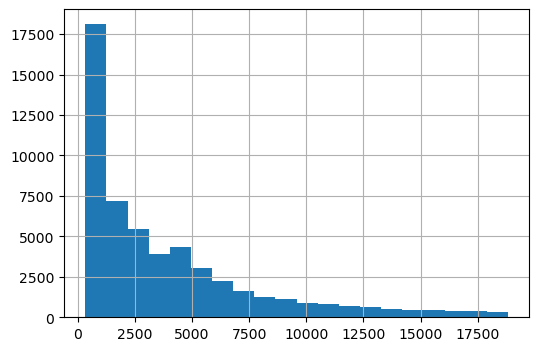

In [13]:
# ダイヤモンド価格のヒストグラム（外れ値除外後）
plt.figure(figsize=(6, 4))
df['price'].hist(bins=20)


## モデル予測(特徴量エンジニアリングなし＆ハイパーパラメータ初期値)

In [15]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [16]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)


X_trainの形状： (43128, 9)  y_trainの形状： (43128,)  X_testの形状： (10783, 9)  y_testの形状： (10783,)


In [17]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43128 non-null  float64
 1   cut      43128 non-null  int64  
 2   color    43128 non-null  int64  
 3   clarity  43128 non-null  int64  
 4   depth    43128 non-null  float64
 5   table    43128 non-null  float64
 6   x        43128 non-null  float64
 7   y        43128 non-null  float64
 8   z        43128 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


In [18]:
# カテゴリ変数のデータ型をcategory型に変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    43128 non-null  float64 
 1   cut      43128 non-null  category
 2   color    43128 non-null  category
 3   clarity  43128 non-null  category
 4   depth    43128 non-null  float64 
 5   table    43128 non-null  float64 
 6   x        43128 non-null  float64 
 7   y        43128 non-null  float64 
 8   z        43128 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 2.4 MB


In [19]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 9)  y_trの形状： (34502,)  X_vaの形状： (8626, 9)  y_vaの形状： (8626,)


In [20]:
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {}

In [21]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500),
                             lgb.record_evaluation(evals_result)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.356	valid's l1: 260.634
[1000]	train's l1: 208.097	valid's l1: 257.966
Early stopping, best iteration is:
[1258]	train's l1: 203.107	valid's l1: 257.68
MAE valid: 257.68


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

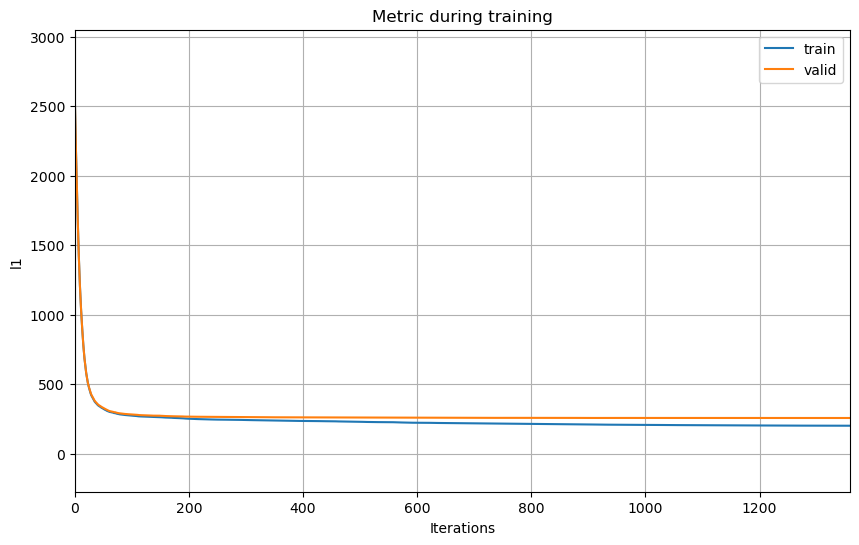

In [22]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [23]:
# 学習が停止したブースティング回数
model.best_iteration

1258

In [24]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) 
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration) 
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE valid: 257.68
MAE test: 262.61


In [25]:
# テストデータの正解値と予測値の比較
print('正解値：', y_test[:5].values)
print('予測値：', y_test_pred[:5])
print('残差=正解値-予測値：', y_test[:5].values - y_test_pred[:5])

正解値： [3353 2930 4155 2780  684]
予測値： [3357.55731496 2933.55703446 4789.28650622 2939.79413242  748.33015008]
残差=正解値-予測値： [  -4.55731496   -3.55703446 -634.28650622 -159.79413242  -64.33015008]


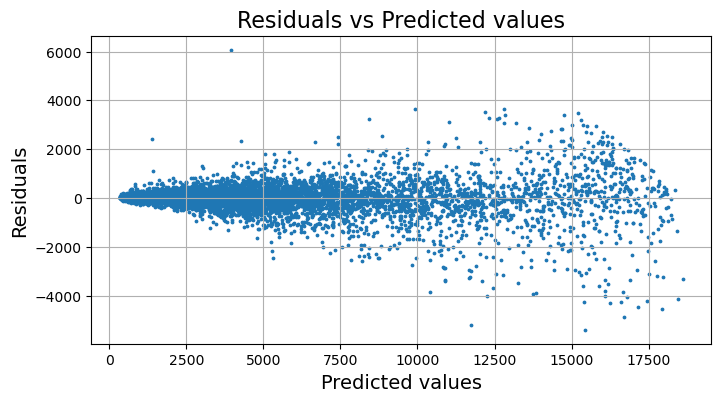

In [26]:
# 残差のプロット

# 残差の計算
residuals = y_test - y_test_pred
# 残差と予測値の散布図
plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.scatter(y_test_pred, residuals, s=3)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted values', fontsize=16)
plt.grid()
plt.show()

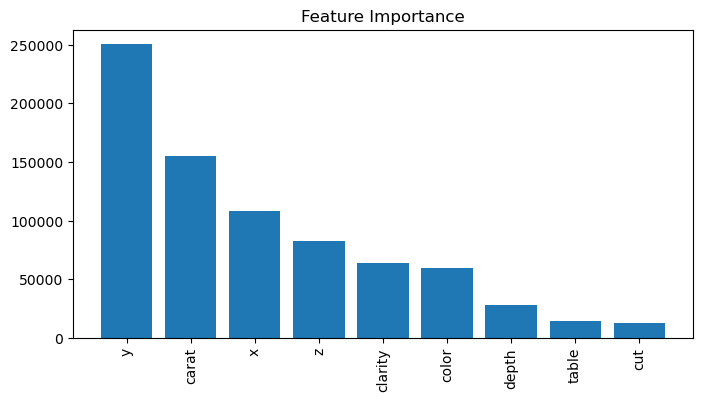

In [27]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示


In [28]:
# ライブラリshapのインストール
!pip install shap


[notice] A new release of pip is available: 23.0 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [29]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_pertubation = 'tree_path_dependent')

In [30]:
# SHAP値の計算
shap_values = explainer(X_test)

In [31]:
# 3件目の予測値
y_test_pred[2]

4789.286506223028

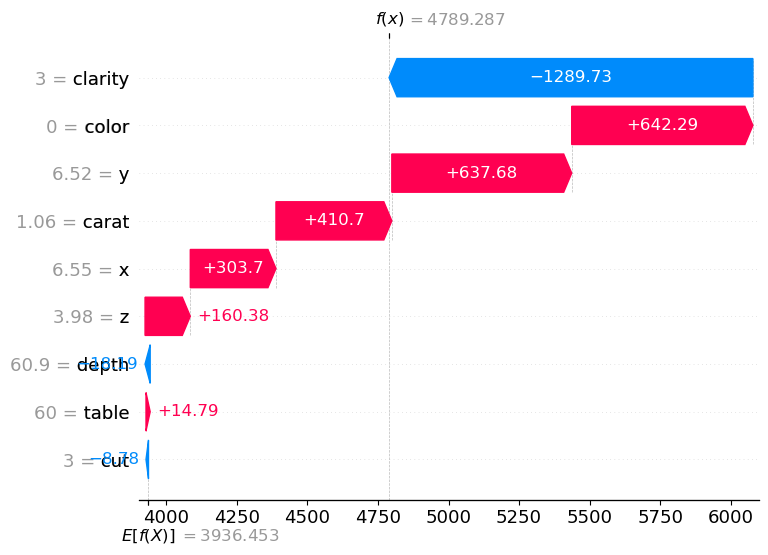

In [32]:
# 3件目のSHAP値の可視化
shap.plots.waterfall(shap_values[2])

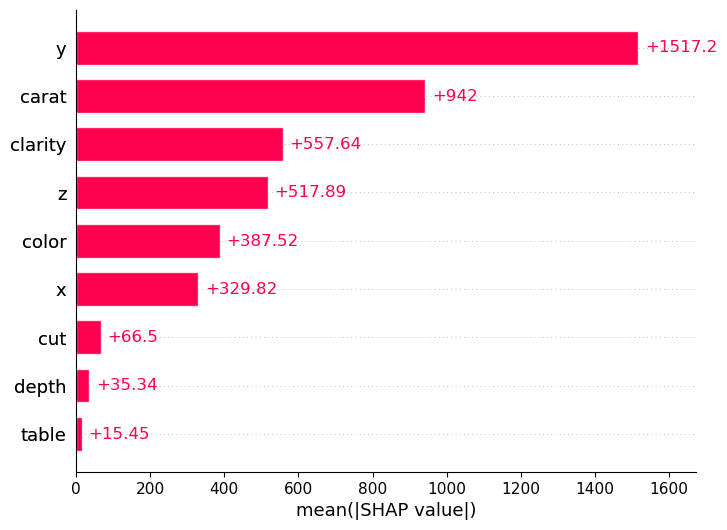

In [33]:
# 重要度の可視化
shap.plots.bar(shap_values)